# Challenge Deep Learning - Entrainement

## Imports

### Imports par défault

In [42]:
import pandas as pd
import numpy as np
import time
from PIL import Image
import glob
import matplotlib.pyplot as plt
%matplotlib inline

### Nos imports

In [43]:
import tensorflow.keras as tk

from tensorflow.keras.layers import Input, Dense, Activation, Lambda, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam

## Données

### Chargement des données à partir d'un CSV

In [44]:
def loadData(fileName) :

    # Lecture d'un fichier CSV
    data = pd.read_csv(fileName)

    # Nombre de ligne dans le CSV
    number_data = len(data)

    images = []
    labels = []

    # Ajout des labels et des images dans des tableaux
    for i in range(0, number_data):
        labels.append(data['class_label'][i])
        image_path = 'data/png-files/'+data['relative_path'][i]
        images.append(np.array(Image.open(image_path)))

    # On convertit ces tableaux en np.array() pour appliquer des fonctions de numpy
    images = np.array(images)
    labels = np.array(labels)
    return (images, labels)

### Méthode pour normaliser les données

In [45]:
def normalizeData(images, labels, classes_number) :

    images_number = len(images)

    # Dimension de l'image
    images_shape = (images.shape[1], images.shape[2])

    # On change le vecteur d'image pour contenir le nombre d'image et les dimensions de l'image
    images = images.reshape(images_number, images_shape[0], images_shape[1], 1)

    # Passer l'image en niveau de gris
    images = (images / 255)

    # Convertie un vecteur d'entier en une matrice binaire
    labels = tk.utils.to_categorical(labels, classes_number)

    return (images, labels) 

### Chargement et Normalisation des données

In [46]:
# Les 5 classes dont on possède les images
classes = ["basket","eye","binoculars","rabbit","hand"]

# Nombre de classes (= 5)
classes_number = len(classes)

# Chargement des données
(train_images, train_labels) = loadData('data/train.csv')
(validation_images, validation_labels) = loadData('data/valid.csv')
(test_images, test_labels) = loadData('data/test.csv')

# Normalisation des données
(train_images, train_labels) = normalizeData(train_images, train_labels, classes_number)
(validation_images, validation_labels) = normalizeData(validation_images, validation_labels, classes_number)
(test_images, test_labels) = normalizeData(test_images, test_labels, classes_number)



## Définition du réseau

### Paramètres

In [47]:

# Taux d'apprentissage 
learning_rate = 0.0001

# Nombre de phases d'entrainement
epochs_number = 100

# Taille d'un groupe image pour effectuer l'entrainement 
batch_size = 128

### Les couches

On a vu dans le TP n°3 intitulé *Réseau convolutif* qui sont des réseaux spécialisés dans le traitement des images. Pour analyser ces images, nous avons 
- Charger ces images 
- Normaliser les images

Ensuite la reconnaissance des motifs se fait de la facon suivante 
- On étudie l'image dans sa globalité (contours)
- Puis on réalise une analyse plus fine (forme, couleur)
- Grâce à cette analyse, on va classifier l'image dans une classe

Concernant le choix de nos couches 
- Utilisation de couches de convolution pour filter 
- Sous Echantillonage pour réduire le bruit de l'image
- Pooling pour la mise en commun des neurones des sorties dits d’agrégation totale ou partielle
- On a appliqué une couche de Dropout pour améliorer nos résultats, et pas simplement réaliser une simple rétropropagation 
- Enfin des couches cachées (Dense)

Fonction d'activation 
- La fonction **relu** : On a vu dans le support de cours sur les réseaux convolutifs que : *l’utilisation d’une couche ReLU en tant que couche non linéaire permettait un entraînement efficace de réseaux profonds*. 
- Le classifieur **softmax** pour définir la classe de l'image.


In [48]:
image_size = train_images.shape[1]

model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5),activation='relu', input_shape=(image_size, image_size, 1),padding='same', name='Layer_Conv2D_1'))
model.add(MaxPooling2D(pool_size=(2, 2), name='Layer_MaxPool2D_1'))
model.add(Dropout(rate=0.25, name='Layer_Dropout_1'))
model.add(Conv2D(64, (2, 2), activation='relu', name='Layer_Conv2D_2'))
model.add(MaxPooling2D(pool_size=(2, 2), name='Layer_MaxPool2D_2'))
model.add(Dropout(rate=0.25, name='Layer_Dropout_2'))
model.add(Conv2D(128, (2, 2), activation='relu', name='Layer_Conv2D_3'))
model.add(MaxPooling2D(pool_size=(2, 2), name='Layer_MaxPool2D_3'))
model.add(Dropout(rate=0.5, name='Layer_Dropout_3'))
model.add(Flatten(name='Layer_Flatten_1'))
model.add(Dense(1024, activation='relu', name='Layer_Dense_1'))
model.add(Dropout(rate=0.5,name='Layer_Dropout_4'))
model.add(Dense(classes_number, activation='softmax', name='Layer_Dense_2'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Layer_Conv2D_1 (Conv2D)      (None, 28, 28, 32)        832       
_________________________________________________________________
Layer_MaxPool2D_1 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
Layer_Dropout_1 (Dropout)    (None, 14, 14, 32)        0         
_________________________________________________________________
Layer_Conv2D_2 (Conv2D)      (None, 13, 13, 64)        8256      
_________________________________________________________________
Layer_MaxPool2D_2 (MaxPoolin (None, 6, 6, 64)          0         
_________________________________________________________________
Layer_Dropout_2 (Dropout)    (None, 6, 6, 64)          0         
_________________________________________________________________
Layer_Conv2D_3 (Conv2D)      (None, 5, 5, 128)        

### Optimisateur et compilation

In [49]:
adam = Adam(learning_rate=learning_rate)
model.compile(loss=tk.losses.categorical_crossentropy,optimizer=adam,metrics=['acc'])

## Entrainement

### Entrainement du model 

Précision finale : 0.95578

In [50]:
hist = model.fit(train_images, train_labels,
          batch_size=batch_size,
          epochs=epochs_number,
          verbose=1,
          validation_data=(validation_images, validation_labels))
score = model.evaluate(test_images, test_labels, verbose=0)
print('Final Accuracy:', score[1]) 

Train on 75000 samples, validate on 25000 samples
Epoch 1/100
75000/75000 [==============================] - 16s 215us/sample - loss: 1.1374 - acc: 0.5494 - val_loss: 0.7101 - val_acc: 0.7556
Epoch 2/100
75000/75000 [==============================] - 15s 195us/sample - loss: 0.7191 - acc: 0.7431 - val_loss: 0.5340 - val_acc: 0.8194
Epoch 3/100
75000/75000 [==============================] - 15s 195us/sample - loss: 0.6013 - acc: 0.7900 - val_loss: 0.4516 - val_acc: 0.8498
Epoch 4/100
75000/75000 [==============================] - 15s 198us/sample - loss: 0.5335 - acc: 0.8183 - val_loss: 0.3979 - val_acc: 0.8699
Epoch 5/100
75000/75000 [==============================] - 15s 201us/sample - loss: 0.4836 - acc: 0.8369 - val_loss: 0.3623 - val_acc: 0.8831
Epoch 6/100
75000/75000 [==============================] - 15s 204us/sample - loss: 0.4472 - acc: 0.8502 - val_loss: 0.3333 - val_acc: 0.8928
Epoch 7/100
75000/75000 [==============================] - 15s 203us/sample - loss: 0.4211 - acc: 

### Sauvegarde du model

In [51]:
model.save("model.h5")

### Affichage des statistiques

On constate que les courbes de validation et d'entrainement sont très proche ce qui indique que le modèle est adapté aux données à traiter

In [52]:
def displayStatModel(label, value) :
    plt.plot(hist.history[value])
    plt.plot(hist.history['val_' + value])
    plt.title(label)
    plt.ylabel(label)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='best')
    plt.tight_layout()
    

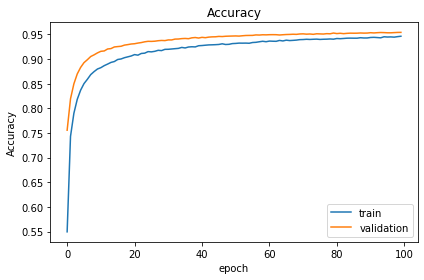

In [53]:
displayStatModel('Accuracy', 'acc')


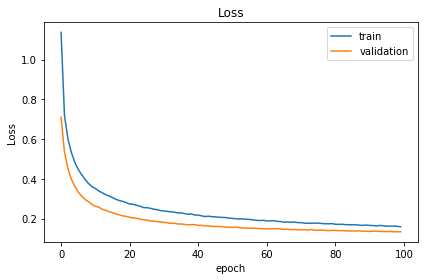

In [54]:
displayStatModel('Loss', 'loss')